In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit,cross_val_predict,cross_validate
import category_encoders as ce
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from joblib import dump

print("module imported")

module imported


In [2]:
df=pd.read_csv("/kaggle/input/future-usage-dataset-3/future_usage_prediction_dataset_3.csv")
print("data sucessfull read")

data sucessfull read


In [3]:
# Display first few rows
print("🔹 First 5 Rows:")
print(df.head())

# Basic info
print("\n🔹 Data Info:")
print(df.info())

# Summary statistics
print("\n🔹 Summary Statistics:")
print(df.describe(include='all'))

# Check for missing values
print("\n🔹 Missing Values:")
print(df.isnull().sum())

# Data types
print("\n🔹 Data Types:")
print(df.dtypes)

🔹 First 5 Rows:
             timestamp device_id device_type room_id  power_consumption  \
0  2024-01-06 13:45:00  device_1       Light  room_1                0.0   
1  2024-01-10 14:15:00  device_1       Light  room_1                0.0   
2  2024-01-10 14:15:00  device_1       Light  room_1                0.0   
3  2024-01-10 14:15:00  device_1       Light  room_1                0.0   
4  2024-01-10 14:15:00  device_1       Light  room_1                0.0   

   occupancy  temperature  humidity weather_condition day_of_week  hour  \
0          5        11.82     46.70            Cloudy    Saturday    13   
1          0        19.58     63.59             Sunny   Wednesday    14   
2          0         7.25     55.80             Windy   Wednesday    14   
3          3        19.58     63.59             Sunny   Wednesday    14   
4          3         7.25     55.80             Windy   Wednesday    14   

   is_weekend  prev_hour_usage  rolling_avg_3hr  rolling_avg_24hr  \
0           1

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [4]:
# Convert timestamp to datetime if not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract date parts
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['month']=df['timestamp'].dt.month

In [5]:
device_dummies = pd.get_dummies(df['device_type'], prefix='temp_device')
for col in device_dummies.columns:
    df[col] = device_dummies[col] * df['temperature']


/tmp/ipykernel_31/3854016619.py:4: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


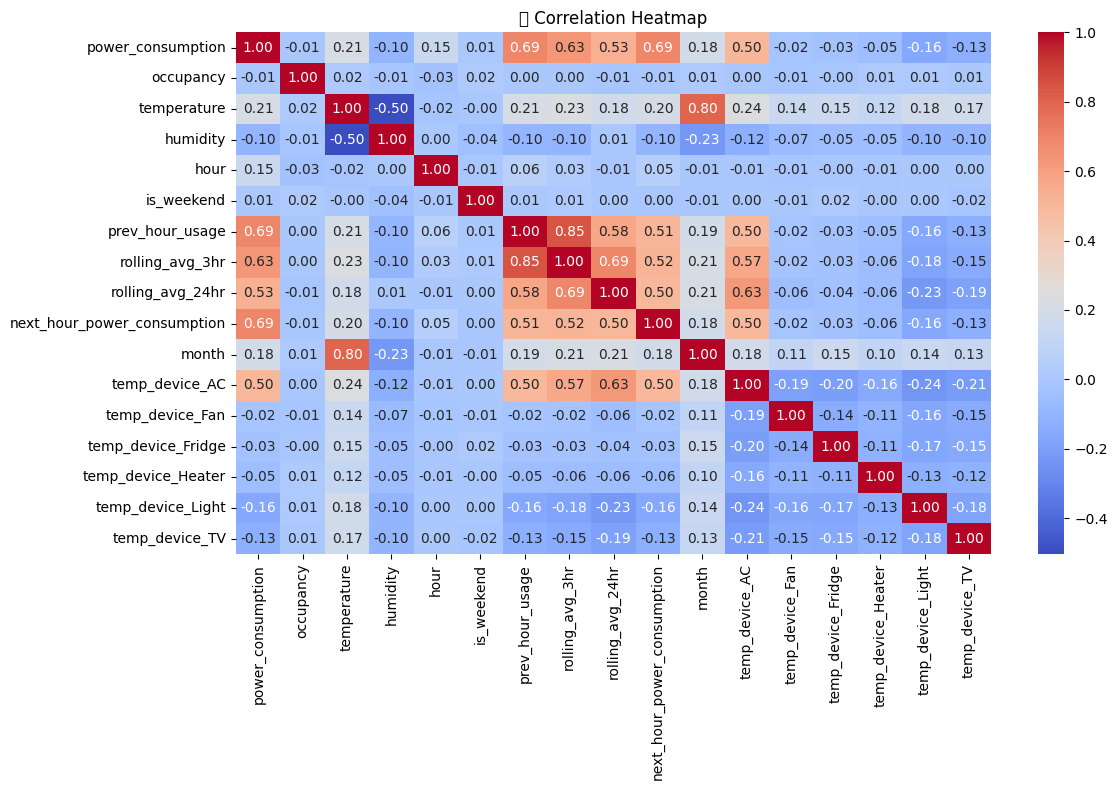

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔍 Correlation Heatmap")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_31/3454684623.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


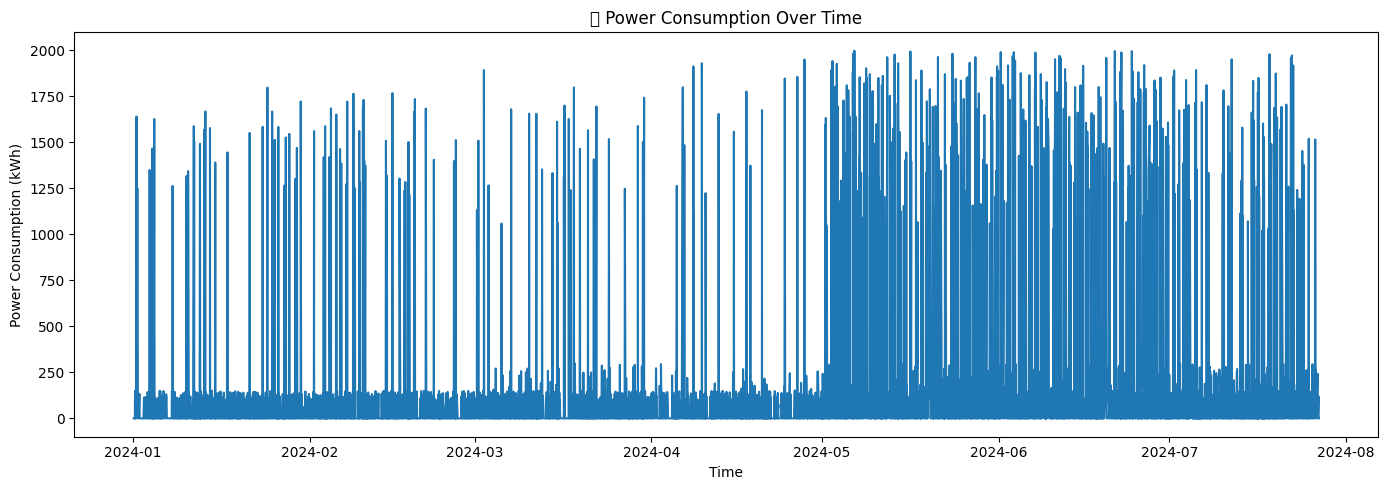

In [7]:
plt.figure(figsize=(14, 5))
sns.lineplot(x='timestamp', y='power_consumption', data=df)
plt.title("📊 Power Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Power Consumption (kWh)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_31/1492080828.py:6: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


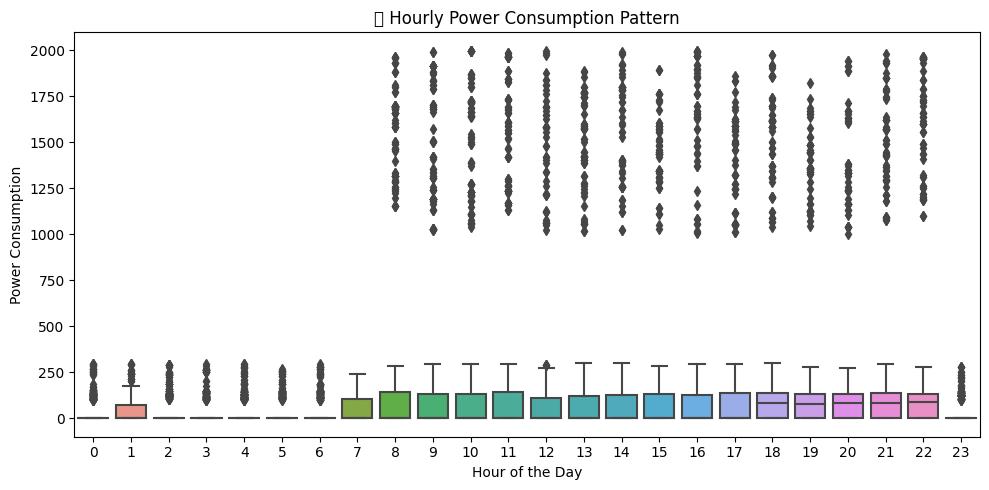

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='hour', y='power_consumption', data=df)
plt.title("⏰ Hourly Power Consumption Pattern")
plt.xlabel("Hour of the Day")
plt.ylabel("Power Consumption")
plt.tight_layout()
plt.show()

/tmp/ipykernel_31/1636947789.py:7: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


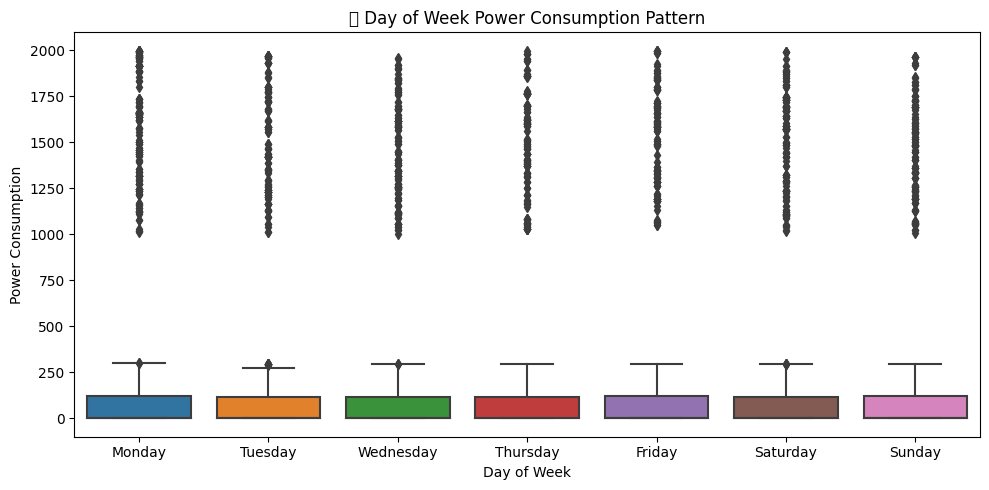

In [9]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='power_consumption', data=df,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("🧭 Day of Week Power Consumption Pattern")
plt.xlabel("Day of Week")
plt.ylabel("Power Consumption")
plt.tight_layout()
plt.show()


/tmp/ipykernel_31/3000064586.py:5: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


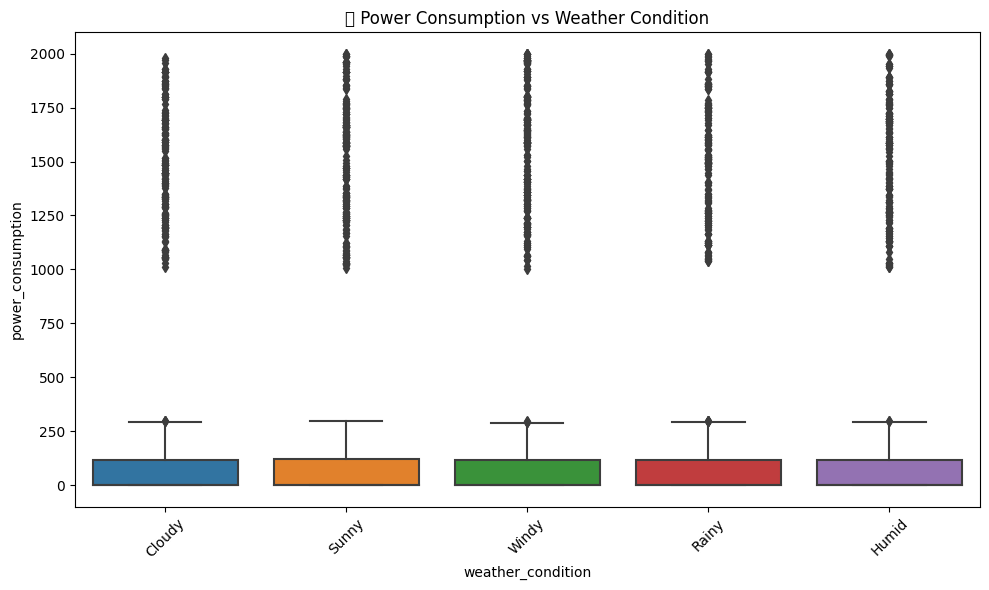

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_condition', y='power_consumption', data=df)
plt.title("💨 Power Consumption vs Weather Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_31/253734592.py:6: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


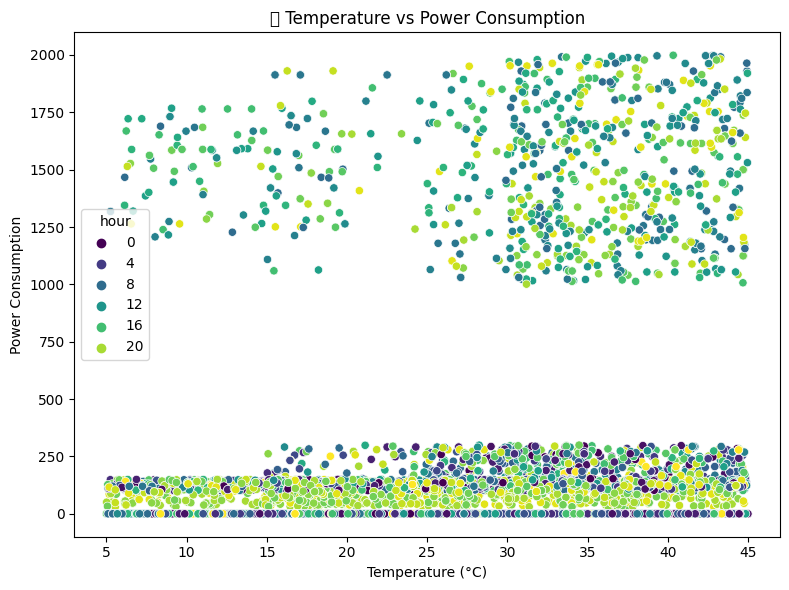

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temperature', y='power_consumption', hue='hour', palette='viridis', data=df)
plt.title("🌡️ Temperature vs Power Consumption")
plt.xlabel("Temperature (°C)")
plt.ylabel("Power Consumption")
plt.tight_layout()
plt.show()

/tmp/ipykernel_31/708684377.py:6: UserWarning: Glyph 129482 (\N{ICE CUBE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129482 (\N{ICE CUBE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


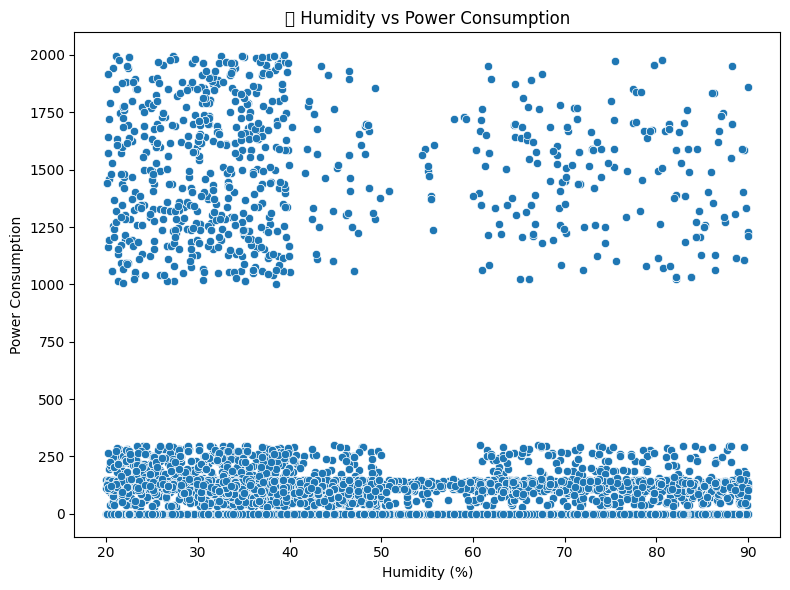

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='humidity', y='power_consumption', data=df)
plt.title("🧊 Humidity vs Power Consumption")
plt.xlabel("Humidity (%)")
plt.ylabel("Power Consumption")
plt.tight_layout()
plt.show()

In [13]:
print("shape of dataset \n",df.shape)
print("first 10 values \n",df.head(100))
print("data types of columns \n",df.dtypes)
print("data summary \n" ,df.describe())
print("null values in data\n",df.isnull().sum())
print("unique values of data \n",df.nunique())

shape of dataset 
 (12534, 23)
first 10 values 
              timestamp device_id device_type room_id  power_consumption  \
0  2024-01-06 13:45:00  device_1       Light  room_1                0.0   
1  2024-01-10 14:15:00  device_1       Light  room_1                0.0   
2  2024-01-10 14:15:00  device_1       Light  room_1                0.0   
3  2024-01-10 14:15:00  device_1       Light  room_1                0.0   
4  2024-01-10 14:15:00  device_1       Light  room_1                0.0   
..                 ...       ...         ...     ...                ...   
95 2024-06-11 12:45:00  device_1       Light  room_1                0.0   
96 2024-06-11 12:45:00  device_1       Light  room_1                0.0   
97 2024-06-11 23:15:00  device_1       Light  room_1                0.0   
98 2024-06-14 03:45:00  device_1       Light  room_1                0.0   
99 2024-06-14 03:45:00  device_1       Light  room_1                0.0   

    occupancy  temperature  humidity weather_condi

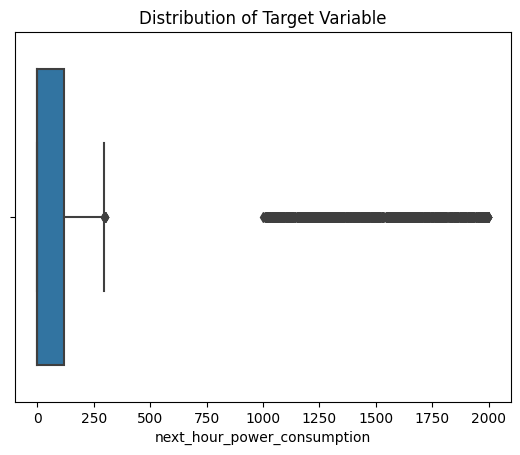

1998.7
156.57520424445508
0      0.00
1      0.00
2      0.00
3      0.00
4     55.67
      ...  
95     0.00
96     0.00
97     0.00
98     0.00
99     0.00
Name: next_hour_power_consumption, Length: 100, dtype: float64


In [14]:
sns.boxplot(x=df['next_hour_power_consumption'])
plt.title("Distribution of Target Variable")
plt.show()

print(df['next_hour_power_consumption'].max())
print(df['next_hour_power_consumption'].mean())
print(df['next_hour_power_consumption'].head(100))

In [15]:
energy_data=df

In [16]:
num_cols=[c for c in energy_data.columns if energy_data[c].dtype in ['int64','float64']]
print(num_cols)

['power_consumption', 'occupancy', 'temperature', 'humidity', 'is_weekend', 'prev_hour_usage', 'rolling_avg_3hr', 'rolling_avg_24hr', 'next_hour_power_consumption', 'temp_device_AC', 'temp_device_Fan', 'temp_device_Fridge', 'temp_device_Heater', 'temp_device_Light', 'temp_device_TV']


In [17]:
scaler = MinMaxScaler()
energy_data_scaled = df.copy()
energy_data_scaled[num_cols] = scaler.fit_transform(energy_data_scaled[num_cols])



In [18]:
print(energy_data.head())
print(energy_data.dtypes)

            timestamp device_id device_type room_id  power_consumption  \
0 2024-01-06 13:45:00  device_1       Light  room_1                0.0   
1 2024-01-10 14:15:00  device_1       Light  room_1                0.0   
2 2024-01-10 14:15:00  device_1       Light  room_1                0.0   
3 2024-01-10 14:15:00  device_1       Light  room_1                0.0   
4 2024-01-10 14:15:00  device_1       Light  room_1                0.0   

   occupancy  temperature  humidity weather_condition day_of_week  ...  \
0          5        11.82     46.70            Cloudy    Saturday  ...   
1          0        19.58     63.59             Sunny   Wednesday  ...   
2          0         7.25     55.80             Windy   Wednesday  ...   
3          3        19.58     63.59             Sunny   Wednesday  ...   
4          3         7.25     55.80             Windy   Wednesday  ...   

   rolling_avg_3hr  rolling_avg_24hr  next_hour_power_consumption  month  \
0              0.0               0

In [19]:

X = energy_data_scaled.drop(['timestamp', 'next_hour_power_consumption'], axis=1)
y=energy_data_scaled['next_hour_power_consumption']
print(X.head())
print(y.head())

  device_id device_type room_id  power_consumption  occupancy  temperature  \
0  device_1       Light  room_1                0.0        1.0      0.17050   
1  device_1       Light  room_1                0.0        0.0      0.36450   
2  device_1       Light  room_1                0.0        0.0      0.05625   
3  device_1       Light  room_1                0.0        0.6      0.36450   
4  device_1       Light  room_1                0.0        0.6      0.05625   

   humidity weather_condition day_of_week  hour  ...  prev_hour_usage  \
0  0.381218            Cloudy    Saturday    13  ...              0.0   
1  0.622642             Sunny   Wednesday    14  ...              0.0   
2  0.511292             Windy   Wednesday    14  ...              0.0   
3  0.622642             Sunny   Wednesday    14  ...              0.0   
4  0.511292             Windy   Wednesday    14  ...              0.0   

   rolling_avg_3hr  rolling_avg_24hr  month  temp_device_AC  temp_device_Fan  \
0           

In [20]:
X, y = shuffle(X, y, random_state=100)
print(X.head())
print(y.head())
print(X.shape)

       device_id device_type room_id  power_consumption  occupancy  \
6962   device_59      Fridge  room_0           0.054115        0.4   
9779    device_8          AC  room_2           0.520518        0.0   
7613   device_63      Fridge  room_1           0.064667        1.0   
922    device_15          TV  room_0           0.000000        1.0   
12357  device_98          TV  room_1           0.072892        0.4   

       temperature  humidity weather_condition day_of_week  hour  ...  \
6962       0.61950  0.973270            Cloudy      Friday    21  ...   
9779       0.64050  0.044311             Rainy    Thursday    20  ...   
7613       0.53725  0.733133            Cloudy      Sunday    18  ...   
922        0.53575  0.291595            Cloudy      Friday    10  ...   
12357      0.35100  0.378502             Rainy    Thursday    22  ...   

       prev_hour_usage  rolling_avg_3hr  rolling_avg_24hr  month  \
6962          0.058133         0.062178          0.091166      7   
9779

In [21]:
cat_cols=[cols for cols in X.columns if X[cols].dtype=='object']
print(cat_cols)

['device_id', 'device_type', 'room_id', 'weather_condition', 'day_of_week']


In [22]:
num_cols=[c for c in X.columns if X[c].dtype in ['int64','float64']]
print(num_cols)

['power_consumption', 'occupancy', 'temperature', 'humidity', 'is_weekend', 'prev_hour_usage', 'rolling_avg_3hr', 'rolling_avg_24hr', 'temp_device_AC', 'temp_device_Fan', 'temp_device_Fridge', 'temp_device_Heater', 'temp_device_Light', 'temp_device_TV']


In [23]:


pipeline=Pipeline(steps=[
    ('target_encoder',ce.TargetEncoder(cols=cat_cols,smoothing=5)),
    ('xgb_model',XGBRegressor(
        n_estimators=10000,
        max_depth=6,
        learning_rate=0.1,
        lambda_=0.5,
        random_state=100
    ))
])

In [24]:

scores=-1*cross_val_score(pipeline,X,y,cv=8,scoring='neg_mean_squared_error')
print("✅ Time Series Cross-Validation MSE Scores:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score:.2f}")
print(f"📊 Avg MSE: {scores.mean():.2f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:50:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:50:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:50:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:50:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:50:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, Use

✅ Time Series Cross-Validation MSE Scores:
Fold 1: 0.03
Fold 2: 0.03
Fold 3: 0.03
Fold 4: 0.02
Fold 5: 0.03
Fold 6: 0.03
Fold 7: 0.02
Fold 8: 0.02
📊 Avg MSE: 0.02


In [26]:
dump(pipeline, 'future usage prediction.joblib')

['future usage prediction.joblib']